### Evaluator-optimizer
In the evaluator-optimizer workflow, one LLM call generates a response while another provides evaluation and feedback in a loop.

When to use this workflow: This workflow is particularly effective when we have clear evaluation criteria, and when iterative refinement provides measurable value. The two signs of good fit are, first, that LLM responses can be demonstrably improved when a human articulates their feedback; and second, that the LLM can provide such feedback. This is analogous to the iterative writing process a human writer might go through when producing a polished document.

In [3]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq
#os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

llm=ChatGroq(model="qwen-qwq-32b")
#llm = ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello")
result

AIMessage(content='\n<think>\nOkay, the user said "Hello". I should respond politely. Maybe say "Hello! How can I assist you today?" That\'s friendly and opens the conversation. Let me check if there\'s anything else I need to consider. No, seems straightforward. Just keep it simple and welcoming.\n</think>\n\nHello! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 70, 'prompt_tokens': 11, 'total_tokens': 81, 'completion_time': 0.175680089, 'prompt_time': 0.002886305, 'queue_time': 0.24522070299999998, 'total_time': 0.178566394}, 'model_name': 'qwen-qwq-32b', 'system_fingerprint': 'fp_1e88ca32eb', 'finish_reason': 'stop', 'logprobs': None}, id='run-94e676f8-73af-4514-9183-6d828aac54ae-0', usage_metadata={'input_tokens': 11, 'output_tokens': 70, 'total_tokens': 81})

In [4]:
from typing import Annotated, List
import operator
from typing_extensions import Literal
from pydantic import BaseModel,Field
from langchain_core.messages import HumanMessage,SystemMessage
from typing_extensions import TypedDict
# Graph state
class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str

In [5]:
# Schema for structured output to use in evaluation
class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(
        description="Decide if the joke is funny or not.",
    )
    feedback: str = Field(
        description="If the joke is not funny, provide feedback on how to improve it.",
    )

# Augment the LLM with schema for structured output
evaluator = llm.with_structured_output(Feedback)

In [7]:
# Nodes
def llm_call_generator(state: State):
    """LLM generates a joke"""

    if state.get("feedback"):
        msg = llm.invoke(
            f"Write a joke about {state['topic']} but take into account the feedback: {state['feedback']}"
        )
    else:
        msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}

def llm_call_evaluator(state: State):
    """LLM evaluates the joke"""

    grade = evaluator.invoke(f"Grade the joke {state['joke']}")
    return {"funny_or_not": grade.grade, "feedback": grade.feedback}

# Conditional edge function to route back to joke generator or end based upon feedback from the evaluator
def route_joke(state: State):
    """Route back to joke generator or end based upon feedback from the evaluator"""

    if state["funny_or_not"] == "funny":
        return "Accepted"
    elif state["funny_or_not"] == "not funny":
        return "Rejected + Feedback"


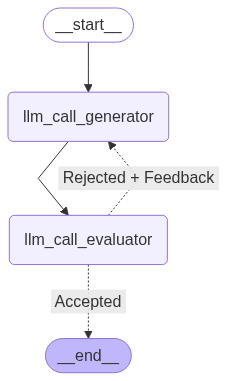

In [8]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# Build workflow
optimizer_builder = StateGraph(State)

# Add the nodes
optimizer_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)

# Add edges to connect nodes
optimizer_builder.add_edge(START, "llm_call_generator")
optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")
optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {  # Name returned by route_joke : Name of next node to visit
        "Accepted": END,
        "Rejected + Feedback": "llm_call_generator",
    },
)

# Compile the workflow
optimizer_workflow = optimizer_builder.compile()
# Show the workflow
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))

In [10]:
# Invoke
state = optimizer_workflow.invoke({"topic": "LLM Hype"})
print(state["joke"])


<think>
Okay, the user wants a joke about LLM Hype. Let me think about this. LLM stands for Large Language Models, right? The hype around them is huge, with everyone talking about how they'll change the world. But maybe there's a way to poke fun at the over-the-top claims.

Hmm, maybe a setup where someone is so hyped they think the LLM can do anything. Like, "Why did the LLM go to therapy?" Then the punchline could be that it's overwhelmed by all the hype, or maybe it's trying to handle too many tasks.

Wait, another angle: people often say LLMs can do anything from writing to coding. So maybe the joke is about the LLM's actual vs. perceived abilities. Like, someone asks the LLM to do something impossible, and the response is a humble or sarcastic reply.

Or maybe play on the "AI winter" fears. The hype is so high, but maybe the LLM is tired of all the expectations. "Why did the LLM bring a ladder to the bar? To reach the hype!" No, that's not quite there.

Alternatively, a tech supp

In [ ]:
state